In [1]:


import torch

print("Torch version:",torch.__version__)

print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.1.0+cpu
Is CUDA enabled? False


Należy dla jedno i dwuwarstwowej sieci neuronowej porównać wyniki i krzywe 
uczenia w zależności od:
• Liczby neuronów w warstwie ukrytej
• Rozmiaru batcha
• Liczby przykładów uczących (należy wykorzystać podzbiory zbioru uczącego o 
różnych rozmiarach zamiast pełnego zbioru uczącego – sprawdzić rozmiary 1% 
danych, 10% danych)
• Zaburzenia danych: dane można zaburzyć dodając do wejściowego batcha 
batch o tych samych wymiarach, wygenerowany jako szum gaussowski o
różnych odchyleniach. Przebadać scenariusze: szum dodany w danych 
testowych vs szum dodany zarówno w testowych, jak i treningowych.

6000
1000
94
16
Epoch 10/100 - Loss: 0.5257911086082458
Epoch 20/100 - Loss: 0.20820866525173187
Epoch 30/100 - Loss: 0.19882352650165558
Epoch 40/100 - Loss: 0.29714304208755493
Epoch 50/100 - Loss: 0.11728012561798096
Epoch 60/100 - Loss: 0.09327348321676254
Epoch 70/100 - Loss: 0.11460945010185242
Epoch 80/100 - Loss: 0.04268401488661766
Epoch 90/100 - Loss: 0.05886691436171532
Epoch 100/100 - Loss: 0.08548075705766678

Training Time (in minutes) = 5.23
[0.7693570256233215, 0.6341719627380371, 0.6428498029708862, 0.5501363277435303, 0.5806227326393127, 0.5275842547416687, 0.4890303909778595, 0.36870577931404114, 0.4076772928237915, 0.5257911086082458, 0.40491533279418945, 0.4339495599269867, 0.32234621047973633, 0.4469663202762604, 0.24062366783618927, 0.3850770890712738, 0.28197991847991943, 0.2684210240840912, 0.4139789044857025, 0.20820866525173187, 0.20318423211574554, 0.15941663086414337, 0.2857760190963745, 0.4129684865474701, 0.33864983916282654, 0.2505640685558319, 0.1660837

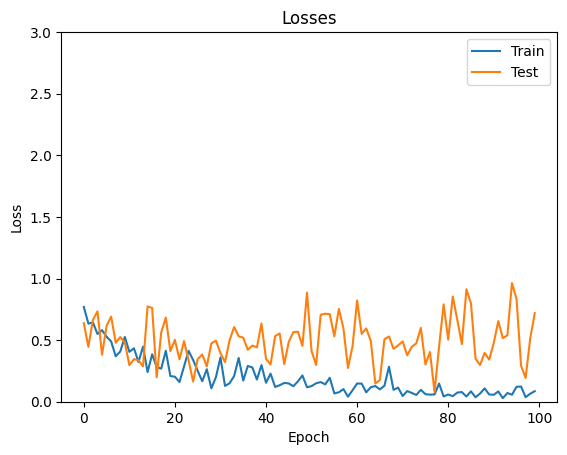

Accuracy: 0.8440
Precision: 0.8431
F1 Score: 0.8428
Epoch 10/100 - Loss: 0.7044081091880798
Epoch 20/100 - Loss: 0.3268345594406128
Epoch 30/100 - Loss: 0.2951597273349762
Epoch 40/100 - Loss: 0.5268896222114563
Epoch 50/100 - Loss: 0.20186102390289307
Epoch 60/100 - Loss: 0.23366403579711914
Epoch 70/100 - Loss: 0.15183429419994354
Epoch 80/100 - Loss: 0.2606426179409027
Epoch 90/100 - Loss: 0.26938721537590027
Epoch 100/100 - Loss: 0.10941856354475021

Training Time (in minutes) = 4.68
[0.9381060600280762, 1.0416746139526367, 0.7312855124473572, 0.7911966443061829, 0.8044729232788086, 0.7603168487548828, 0.601556122303009, 0.5059042572975159, 0.6217890977859497, 0.7044081091880798, 0.5108538269996643, 0.48419392108917236, 0.606530487537384, 0.3375120162963867, 0.35267820954322815, 0.3263867497444153, 0.3475078046321869, 0.4160475432872772, 0.4407139718532562, 0.3268345594406128, 0.46716323494911194, 0.30713561177253723, 0.27544787526130676, 0.21267135441303253, 0.2585087716579437, 0.

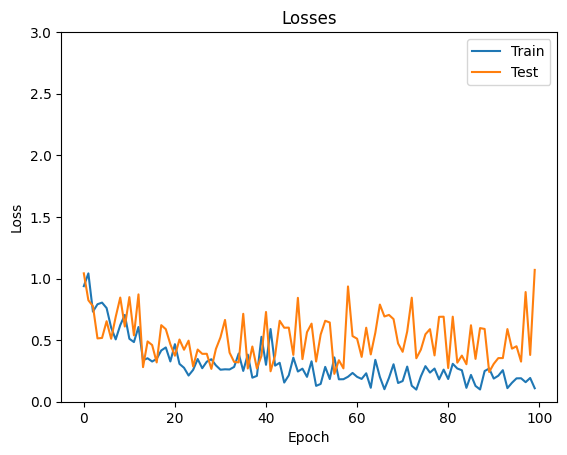

In [21]:
import time
from torchvision import transforms, datasets
import torch
from torch.utils.data import Subset
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.init as init
import random
from sklearn.metrics import precision_score, accuracy_score, f1_score
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,), (0.5,))])

#how to get train and test data
train_data = datasets.FashionMNIST('path', download=True, train=True, transform=transform)
test_data = datasets.FashionMNIST('path', download=True, train=False, transform=transform)


train_indices = list(range(len(train_data)))
random.shuffle(train_indices)
train_indices_10_percent = train_indices[:len(train_indices)//10]

test_indices = list(range(len(test_data)))
random.shuffle(test_indices)
test_indices_10_percent = test_indices[:len(test_indices)//10]

train_data_10_percent = Subset(train_data, train_indices_10_percent)
test_data_10_percent = Subset(test_data, test_indices_10_percent)


print(len(train_data_10_percent))
print(len(test_data_10_percent))
#Define a dataloader to load data
train_loader = torch.utils.data.DataLoader(train_data_10_percent, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data_10_percent, batch_size=64, shuffle=True)

train_loader_big_batch = torch.utils.data.DataLoader(train_data_10_percent, batch_size=16, shuffle=True)
test_loader_big_batch = torch.utils.data.DataLoader(test_data_10_percent, batch_size=16, shuffle=True)

print(len(train_loader))
print(len(test_loader))    
def train(model, criterion, optimizer, data_loader, test_loader, epochs):
    strart_timestamp = time.time()
    training_loss = []
    test_loss = []
    for epoch in range(epochs):
        for images, labels in data_loader:
            # Flatten images
            images = images.view(images.shape[0], -1)
            # Zero out the gradients
            optimizer.zero_grad()
            # Forward pass, get our logits
            logits = model(images)
            # Calculate the loss with the logits and the labels
            loss = criterion(logits, labels)
            # Backward pass
            loss.backward()
            # Update the weights
            optimizer.step()

        training_loss.append(loss.item())
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item()}")
        with torch.no_grad():
            for images, labels in test_loader:
                # Flatten images
                images = images.view(images.shape[0], -1)
                # Forward pass, get our logits
                logits = model(images)
                # Calculate the loss with the logits and the labels
                loss = criterion(logits, labels)
            test_loss.append(loss.item())

    print(f"\nTraining Time (in minutes) = {(time.time()-strart_timestamp)/60:.2f}")
    print(training_loss, test_loss)
    return training_loss, test_loss

def plot_loss(losses, title):
    train, test = losses
    plt.plot(train)
    plt.plot(test)
    plt.legend(['Train', 'Test'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0, 3)
    plt.show()

# Define the network architecture
oneLayerModel = nn.Sequential(
                    nn.Linear(784, 128),
                    nn.LeakyReLU(),
                    nn.Linear(128, 10),
                    nn.LogSoftmax(dim = 1))

oneLayerModel_big_batch = nn.Sequential(
                    nn.Linear(784, 128),
                    nn.LeakyReLU(),
                    nn.Linear(128, 10),
                    nn.LogSoftmax(dim = 1))

oneLayerModel_less_neurons = nn.Sequential(
    nn.Linear(784, 32),
                      nn.LeakyReLU(),
                      nn.Linear(32, 10),
                      nn.LogSoftmax(dim = 1))



def init_xavier(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        init.constant_(m.bias, 0)

oneLayerModel.apply(init_xavier)
oneLayerModel_less_neurons.apply(init_xavier)

# Define the loss
criterion = nn.NLLLoss();

# Define the optimizer
oneLayerModel_optimizer = optim.Adam(oneLayerModel.parameters(), lr=0.0002)
oneLayerModel_big_batch_optimizer = optim.Adam(oneLayerModel_big_batch.parameters(), lr=0.0002)
oneLayerModel_less_neurons_optimizer = optim.Adam(oneLayerModel_less_neurons.parameters(), lr=0.0002)
epochs = 100

def evaluate_model(model, test_loader):
    model.eval()
    total = 0
    correct = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    accuracy = correct / total
    precision = precision_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1 Score: {f1:.4f}')


oneLayerModel_losses = train(
    oneLayerModel, 
    criterion, 
    oneLayerModel_optimizer, 
    train_loader, test_loader, 
    epochs=epochs)
plot_loss(oneLayerModel_losses, 'Losses')
evaluate_model(oneLayerModel, test_loader)

oneLayerModel_less_neurons_losses = train(
    oneLayerModel_less_neurons, 
    criterion, oneLayerModel_less_neurons_optimizer, 
    train_loader, 
    test_loader, 
    epochs=epochs)
plot_loss(oneLayerModel_less_neurons_losses, 'Losses')
evaluate_model(oneLayerModel_less_neurons, test_loader)


oneLayerModel_losses_big_batch = train(
    oneLayerModel_big_batch, 
    criterion, 
    oneLayerModel_big_batch_optimizer, 
    train_loader_big_batch, 
    test_loader_big_batch, 
    epochs=epochs)
plot_loss(oneLayerModel_losses_big_batch, 'Losses')
evaluate_model(oneLayerModel_big_batch, test_loader_big_batch)

